# Распознавание эмоций

Классификатор - предобученная MobileNet на весах imagenet. В качестве детектора работает алгоритм Хаара 

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model, load_model
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D,MaxPooling2D,ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import cv2
import os
import glob
from datetime import datetime
from time import sleep
import numpy as np

In [2]:
print("TF Version: ", tf.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.1.0
GPU is available


In [26]:
# Пути

ROOT_PATH  = os.path.abspath('.')
TRAIN_DATA_PATH = os.path.join(ROOT_PATH, 'train')
VALIDATION_DATA_PATH = os.path.join(ROOT_PATH, 'validation')
STORED_FRAMES_DIR = 'data' # папка для сохранения snapshot'ов
OUTPUT_DIR = 'output'
OUTPUT_DATA_PATH = os.path.join(ROOT_PATH, OUTPUT_DIR)

# Сеттинги

IMG_SIZE = (224, 224, 3)
batch_size = 8
epochs = 50



CLASS_DICT = {"1": "smile",
              "2": "sad",
              "3": "surprised",
              "4": "anger",
              "5": "boared",
              "6": "trick"
             }

class_labels = list(CLASS_DICT.values())
num_classes = len(CLASS_DICT)

In [33]:
# Список изображений в датасете
def get_filenames_list(classes, path, mode='train'):
    dataset = []
    if mode == 'train':
        for cls in classes:
            print('Processing class: {}'.format(cls))
            for fpath in glob.glob(os.path.join(path, cls, '*.jpg')):
                cls_idx = classes.index(cls)
                dataset.append((fpath, cls_idx))
    else:
        for fpath in glob.glob(os.path.join(path, '*.jpg')):
            dataset.append(fpath)
    print('Done')
    return dataset

In [5]:
train_samples = get_filenames_list(class_labels, TRAIN_DATA_PATH)
val_samples = get_filenames_list(class_labels, VALIDATION_DATA_PATH)

n_train_samples = len(train_samples)
n_val_samples = len(val_samples)

Processing class: smile
Processing class: sad
Processing class: surprised
Processing class: anger
Processing class: boared
Processing class: trick
Done
Processing class: smile
Processing class: sad
Processing class: surprised
Processing class: anger
Processing class: boared
Processing class: trick
Done


In [6]:
from math import sqrt as sq
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [36]:
# Принимает на вход список файлов, выводит матрицу изображений с метками с заданным размером
def plot_images_grid(data, n, mode='train'):
    samples = random.sample(data, n)
#     img_samples list(zip(*samples))[0]
#     label_samples list(zip(*samples))[0]
    
    plt.figure(figsize=(16,12))
    
    # В данном датасете [0] элементом являются метки класса, [1] - само изображение
    for i, sample in enumerate(samples):
        plt.subplot(sq(n)+1,sq(n),i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if mode == 'train':
            plt.imshow(mpimg.imread(sample[0]))
            plt.xlabel(class_labels[sample[1]])
        else:
            plt.imshow(mpimg.imread(sample))
    plt.show()

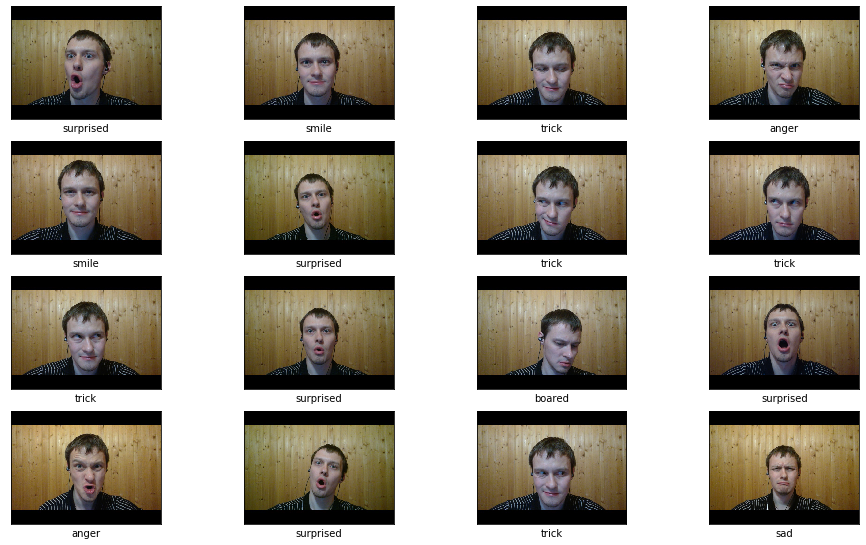

In [14]:
plot_images_grid(train_samples, 16)

## Модуль обучения

#### Сбор и подготовка датасета 

In [81]:
def make_train_filestructure():
    
    # Создает директории с именами классов

    for cls in CLASS_DICT.values():
        d = os.path.join(ROOT_PATH, STORED_FRAMES_DIR, cls)
        if not os.path.exists(d):
            os.mkdir(d)
            print(f"Created {cls} dir")

make_train_filestructure()

Created smile dir
Created sad dir
Created surprised dir
Created anger dir
Created boared dir
Created trick dir


In [82]:
# Запись семплов с камеры

def run_cam_in_dataset_creation_mode():
    
    """
    Usage:
    Выбираем класс из controls, корчим соответствующую рожицу, сохраняем по 's'
    
    Controls: 
    q - exit
    s - take snapshot
    1 - choose "smile" class
    2 - choose "sad" class
    3 - choose "surprized" class
    4 - choose "anger" class
    5 - choose "boared" class
    6 - choose "trick" class
    """
    
    cap = cv2.VideoCapture(0)
    cur_class = CLASS_DICT.get('1')
    img_counter = 0
    while True:
        # Покадровое чтение захвата
        success, frame = cap.read()
        cv2.imshow('Emotion Detector',frame)
        
        # Options
        
        k = cv2.waitKey(1) & 0xFF
        if k == ord('q'): # wait for ESC key to exit
            break
        elif k == ord('1'):
            print(f"Class changed to {CLASS_DICT.get('1')}")
            cur_class = CLASS_DICT.get('1')
        elif k == ord('2'):
            print(f"Class changed to {CLASS_DICT.get('2')}")
            cur_class = CLASS_DICT.get('2')
        elif k == ord('3'):
            print(f"Class changed to {CLASS_DICT.get('3')}")
            cur_class = CLASS_DICT.get('3')
        elif k == ord('4'):
            print(f"Class changed to {CLASS_DICT.get('4')}")
            cur_class = CLASS_DICT.get('4')        
        elif k == ord('5'):
            print(f"Class changed to {CLASS_DICT.get('5')}")
            cur_class = CLASS_DICT.get('5')            
        elif k == ord('6'):
            print(f"Class changed to {CLASS_DICT.get('6')}")
            cur_class = CLASS_DICT.get('6')            
        elif k == ord('s'):
            fn_gen = f"frame{str(datetime.now()).replace(':','-')}{cur_class}.jpg"
            cv2.imwrite(f"./data/{cur_class}/{fn_gen}", frame)
            img_counter += 1
            print(f"Saved img # {img_counter} to {cur_class}")

    cap.release()
    cv2.destroyAllWindows()
    return

In [84]:
run_cam_in_dataset_creation_mode()

Class changed to anger
Saved img # 1 to anger
Saved img # 2 to anger
Saved img # 3 to anger
Saved img # 4 to anger
Saved img # 5 to anger
Saved img # 6 to anger
Saved img # 7 to anger
Saved img # 8 to anger
Saved img # 9 to anger


## Подготовка и обучение модели

In [85]:
# MobileNet работает с изображениями размерности 224, 224
MobileNet = tf.keras.applications.MobileNet(weights='imagenet',include_top=False,input_shape=IMG_SIZE)

In [86]:
# Set layers trainable
for layer in MobileNet.layers:
    layer.trainable = True

# print layers
# for (i,layer) in enumerate(MobileNet.layers):
#     print(str(i),layer.__class__.__name__,layer.trainable)

In [87]:
def addTopModelMobileNet(bottom_model, num_classes):
    
    """ Добавление  финальных слоев на выход модели"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    
    top_model = Dense(1024,activation='relu')(top_model)
    
    top_model = Dense(512,activation='relu')(top_model)
    
    top_model = Dense(num_classes,activation='softmax')(top_model)

    return top_model

FC_Head = addTopModelMobileNet(MobileNet, num_classes)

In [88]:
model = Model(inputs = MobileNet.input, outputs = FC_Head)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [89]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    width_shift_range=0.3,
                    height_shift_range=0.3,
                    horizontal_flip=True,
                    fill_mode='nearest'
                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
                        TRAIN_DATA_PATH,
                        target_size = IMG_SIZE[:2],
                        batch_size = batch_size,
                        class_mode = 'categorical'
                        )

validation_generator = validation_datagen.flow_from_directory(
                            VALIDATION_DATA_PATH,
                            target_size=IMG_SIZE[:2],
                            batch_size=batch_size,
                            class_mode='categorical')

Found 148 images belonging to 6 classes.
Found 38 images belonging to 6 classes.


In [90]:
checkpoint = ModelCheckpoint(
                             'my_emotions_model.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(
                          monitor='loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)

callbacks = [earlystop,checkpoint,learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy']
              )


history = model.fit(
            train_generator,
            steps_per_epoch=n_train_samples//batch_size,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=validation_generator,
            validation_steps=n_val_samples//batch_size)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 18 steps, validate for 3 steps
Epoch 1/50
17/18 [===========================>..] - ETA: 1s - loss: 2.0048 - accuracy: 0.3485
Epoch 00001: val_loss improved from inf to 2.19646, saving model to my_emotions_model.h5
18/18 [==============================] - 28s 2s/step - loss: 1.9729 - accuracy: 0.3643 - val_loss: 2.1965 - val_accuracy: 0.3750
Epoch 2/50
17/18 [===========================>..] - ETA: 0s - loss: 1.2953 - accuracy: 0.4167
Epoch 00002: val_loss did not improve from 2.19646
18/18 [==============================] - 18s 992ms/step - loss: 1.2513 - accuracy: 0.4429 - val_loss: 3.0324 - val_accuracy: 0.4583
Epoch 3/50
17/18 [===========================>..] - ETA: 0s - loss: 0.9316 - accuracy: 0.6742
Epoch 00003: val_loss improved from 2.19646 to 1.81232, saving model to my_emotions_model.h5
18/18 [==============================] - 17s 959ms/step - loss: 0.8862 - accuracy: 0.6929 - val_loss: 1.8123 - val_accuracy: 0.5000
E

Epoch 28/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0131 - accuracy: 1.0000
Epoch 00028: val_loss improved from 0.10473 to 0.08867, saving model to my_emotions_model.h5
18/18 [==============================] - 17s 964ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9583
Epoch 29/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0146 - accuracy: 0.9924
Epoch 00029: val_loss did not improve from 0.08867
18/18 [==============================] - 18s 1s/step - loss: 0.0139 - accuracy: 0.9929 - val_loss: 0.1247 - val_accuracy: 0.9583
Epoch 30/50
17/18 [===========================>..] - ETA: 1s - loss: 0.0098 - accuracy: 0.9924
Epoch 00030: val_loss did not improve from 0.08867
18/18 [==============================] - 19s 1s/step - loss: 0.0094 - accuracy: 0.9929 - val_loss: 0.1298 - val_accuracy: 0.9583
Epoch 31/50
17/18 [===========================>..] - ETA: 1s - loss: 0.0192 - accuracy: 0.9926
Epoch 00031: val_loss did not impro

## Модуль Inference

cv2.CascadeClassifier parms:


**image** – исходное изображение

**scaleFactor** – определяет то, на сколько будет увеличиваться скользящее окно поиска на каждой итерации. 1.1 означает на 10%, 1.05 на 5% и т.д. Чем больше это значение, тем быстрее работает алгоритм.

**minNeighbors** — Чем больше это значение, тем более параноидальным будет поиск и тем чаще он будет пропускать реальные лица, считая, что это ложное срабатывание. Оптимальное значение 3-6.

**minSize** – минимальный размер лица на фото. 30 на 30 обычно вполне достаточно.

In [15]:
# Классификатора Хаара
face_classifier = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
# Загрузка весов
classifiers = ['my_emotions_model.h5','emotion_face_mobilNet.h5', 'Emotion_Detection.h5']
classifier = load_model(classifiers[0])

In [16]:
classifier.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [22]:
def run_cam_in_detection_mode():
    
    """Runs model and predicts label
    Stores snapshots by hitting 's' key """
    
    cap = cv2.VideoCapture(0)

    while True:
        # Покадровое чтение захвата
        success, frame = cap.read()
        labels = []
        faces = face_classifier.detectMultiScale(frame,1.3,5)

        for (x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
            roi_gray = frame[y:y+h,x:x+w]
            roi_gray = cv2.resize(roi_gray,(224,224))
            
            if np.sum([roi_gray])!=0:
                roi = roi_gray.astype('float')/255.0
                roi = img_to_array(roi)
                roi = np.expand_dims(roi,axis=0)
                
                # make a prediction on the ROI, then lookup the class
                
                preds = classifier.predict(roi)[0]
                label=class_labels[preds.argmax()]
                label_position = (x,y)
                cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
                
            else:
                cv2.putText(frame,'No Face Found',(20,60),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
        cv2.imshow('Emotion Detector',frame)
        
        k = cv2.waitKey(1) & 0xFF
        if k == ord('q'): # wait for ESC key to exit
            break
        elif k == ord('s'):
            fn_gen = f"frame{str(datetime.now()).replace(':','-')}.jpg"
            print(fn_gen)
            cv2.imwrite(f"./{OUTPUT_DIR}/{fn_gen}", frame)
            
            print('Image saved')

    cap.release()
    cv2.destroyAllWindows()
    return


In [25]:
run_cam_in_detection_mode()

preds is [0.16697264 0.35728002 0.12705903 0.10311973 0.13999934 0.10556922]
preds is [0.1718554  0.24161416 0.10711412 0.15043439 0.22065154 0.10833046]
preds is [0.1421962  0.13354595 0.1054806  0.23447068 0.29811352 0.08619301]
preds is [0.15290323 0.24313748 0.09543364 0.14022036 0.27027786 0.09802747]
preds is [0.159504   0.27398634 0.11573672 0.1285958  0.2067054  0.1154717 ]
preds is [0.16251323 0.29671863 0.11426114 0.12089144 0.19079468 0.11482085]
preds is [0.16003473 0.2874539  0.13457812 0.1192052  0.1732307  0.12549734]
preds is [0.12671785 0.15951595 0.09696779 0.15110809 0.3749073  0.09078299]
preds is [0.15842074 0.3442509  0.11663613 0.10209623 0.1639883  0.11460774]
preds is [0.1534814  0.27451357 0.09976404 0.12956484 0.24178936 0.10088679]
preds is [0.12048562 0.12163763 0.0897169  0.24768032 0.35414752 0.066332  ]
preds is [0.06353086 0.03091339 0.04967811 0.5834391  0.24404904 0.02838942]
preds is [0.07649404 0.06161149 0.05122542 0.22219586 0.5521366  0.03633662]

preds is [0.12579636 0.04049642 0.05556555 0.52220494 0.2200871  0.0358496 ]
preds is [0.12258469 0.05219728 0.06620137 0.45618138 0.26016533 0.04266997]
preds is [0.12172677 0.03656394 0.0509888  0.53130436 0.2272028  0.03221333]
preds is [0.10092115 0.03068696 0.0447629  0.56699264 0.23000017 0.02663617]
preds is [0.11957495 0.04827845 0.06564053 0.4899969  0.23383063 0.04267851]
preds is [0.14585203 0.01775427 0.02533042 0.5780883  0.21668555 0.01628945]
preds is [0.13035767 0.07813053 0.06711508 0.28475365 0.39031982 0.04932322]
preds is [0.12842266 0.08648897 0.07538145 0.28508154 0.36959466 0.05503071]
preds is [0.08233492 0.02940038 0.04579823 0.5917796  0.22420119 0.02648566]
preds is [0.0511891  0.00752258 0.01418962 0.7937217  0.12599391 0.00738317]
preds is [0.06173382 0.01648541 0.02818096 0.71481884 0.16295598 0.01582504]
preds is [0.06083199 0.01369286 0.02357733 0.7433353  0.14539127 0.01317127]
preds is [0.10366247 0.03900859 0.05417845 0.5410276  0.22843903 0.03368384]

preds is [0.11927588 0.573981   0.03773639 0.05088973 0.17052822 0.0475888 ]
preds is [0.12217035 0.54520386 0.04240334 0.05067368 0.18417132 0.05537749]
preds is [0.11320625 0.45627457 0.03294658 0.05869389 0.29497543 0.04390332]
preds is [0.10488936 0.7093607  0.03480805 0.03067658 0.08031274 0.03995266]
preds is [0.07380283 0.1096411  0.02989236 0.10455002 0.6520117  0.03010195]
preds is [0.09465317 0.6640225  0.02648827 0.03108796 0.14766975 0.03607834]
preds is [0.0775508  0.7706609  0.01810754 0.01992958 0.08949858 0.02425261]
preds is [0.08960062 0.4265266  0.02137279 0.04840347 0.3846032  0.02949332]
preds is [0.08812735 0.48293054 0.01884185 0.04152092 0.3414121  0.0271672 ]
preds is [0.10935792 0.52934027 0.0291262  0.05199185 0.24093112 0.03925266]
preds is [0.12917712 0.5157571  0.03849202 0.06080401 0.20715582 0.04861399]
preds is [0.09215099 0.2222106  0.02639153 0.0896287  0.5388886  0.03072965]
preds is [0.08979071 0.28514197 0.02428399 0.06641886 0.50284666 0.03151784]

preds is [0.07765113 0.02556731 0.04146728 0.65413463 0.17549975 0.02567998]
preds is [0.14707994 0.08932365 0.10005962 0.33661714 0.25375572 0.07316396]
preds is [0.13078435 0.06578063 0.08048822 0.4212884  0.24665967 0.05499877]
preds is [0.09940997 0.02876763 0.04187337 0.60799354 0.19565801 0.02629746]
preds is [0.1478743  0.20682774 0.08286921 0.15277466 0.327083   0.0825711 ]
preds is [0.11535794 0.06396057 0.08124919 0.4284961  0.257084   0.05385217]
preds is [0.12835462 0.08814051 0.09574676 0.3463733  0.27517754 0.0662073 ]
preds is [0.10093493 0.04864248 0.06493048 0.49544656 0.24917912 0.04086647]
preds is [0.14465673 0.15177846 0.09106265 0.22744654 0.31038532 0.07467029]
preds is [0.16765505 0.42664978 0.0734892  0.09795656 0.16101041 0.07323896]
preds is [0.13570179 0.56465876 0.06911064 0.05360489 0.10465132 0.07227261]
preds is [0.06082017 0.8491422  0.02629789 0.01110786 0.0273098  0.02532203]
preds is [0.09014467 0.74317604 0.03437771 0.02472848 0.07068028 0.03689274]

preds is [0.00981822 0.00113939 0.00307541 0.9354219  0.04919372 0.00135138]
preds is [0.03792443 0.01205848 0.02302756 0.7705853  0.14398414 0.01242   ]
preds is [0.05540423 0.01494645 0.02510043 0.69664794 0.19448121 0.01341977]
preds is [0.01057658 0.00185314 0.00485871 0.9180202  0.06254374 0.00214771]
preds is [7.2850343e-03 7.4208446e-04 2.1422035e-03 9.4831902e-01 4.0626206e-02
 8.8548672e-04]
preds is [0.02889574 0.00720868 0.01484596 0.82313555 0.11843171 0.00748234]
preds is [0.02306303 0.005499   0.01154406 0.815499   0.13916993 0.00522481]
preds is [0.06513678 0.02561298 0.0355303  0.53270984 0.3218908  0.01911932]
preds is [0.02068052 0.00333269 0.00748944 0.8793528  0.08559933 0.00354517]
preds is [0.03519976 0.00926084 0.01001345 0.38230902 0.55753523 0.00568167]
preds is [0.01130991 0.00095318 0.00250097 0.9219202  0.06230739 0.00100836]
preds is [0.03743153 0.00681453 0.0106879  0.6801728  0.25975934 0.00513395]
preds is [0.06020101 0.01072718 0.01648329 0.6682726  0.2

preds is [0.1335345  0.13397469 0.05447591 0.20251451 0.42519584 0.05030455]
preds is [0.11858544 0.09540237 0.0470905  0.24131677 0.45903406 0.03857084]
preds is [0.13671438 0.11270821 0.0631306  0.30454475 0.3368195  0.0460825 ]
preds is [0.12821461 0.12323042 0.0480039  0.21690461 0.44094917 0.04269727]
preds is [0.13737541 0.08306255 0.051519   0.30450684 0.3837373  0.03979898]
preds is [0.09307583 0.04477519 0.0405238  0.367907   0.42797518 0.02574291]
preds is [0.07677823 0.02695378 0.03412865 0.5741709  0.2697577  0.01821066]
preds is [0.11689075 0.6598152  0.05139212 0.03668273 0.07953006 0.05568912]
preds is [0.11560364 0.67398703 0.05466075 0.03537897 0.06581775 0.05455182]
preds is [0.13224566 0.6111357  0.06071497 0.04698562 0.08848225 0.06043579]


In [34]:
res_samples = get_filenames_list(class_labels, OUTPUT_DATA_PATH, mode='inf')

Done


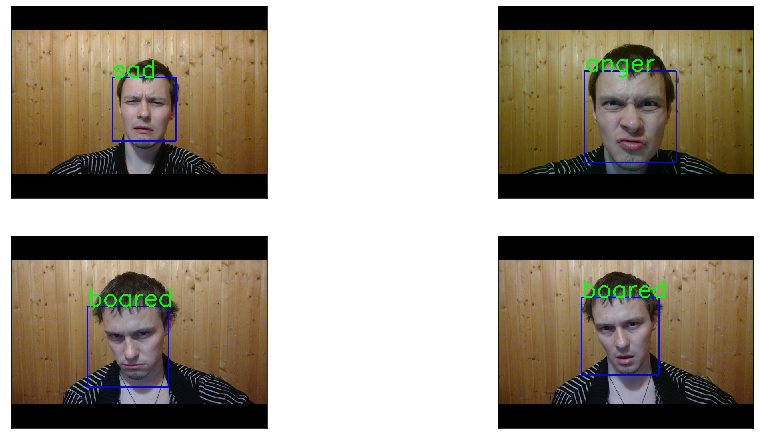

In [40]:
plot_images_grid(res_samples, 4, mode=None)